# On-policy first-visit MC control (for ε-soft policies)

Soft policies are probabilistic, the action picked for state s is the result of sampling the distribution Q(s,:)

On-policy methods never deviate from the policy, but the policy itself is probabilistic, so it allows for the exploration to happen while staying on policy.

In [1]:
import numpy as np
from numpy.linalg import inv, norm
from numpy.random import choice

#Blackjack rules
#draw at random 1 - 10, 10 ,10, 10
#dealer shows one card.
#player takes two and holds on 20 or 21
#state is dealer-showing, player sum and useable ace.
#dealer sticks on 17 or greater

In [2]:
# Usable Ace
def uaFunc(pCards):
    return int(min(pCards) == 1 and sum(pCards) <= 11) 

In [3]:
def stateIdx(dCard, pCards):
    i = dCard - 1
    k = uaFunc(pCards)
    j = pSum(pCards) - 12
    return [i, j, k] 

In [4]:
def pSum(cards):
    return sum(cards) + 10*uaFunc(cards)

In [5]:
def initState():
    dCard = choice(cards)
    pCards = list(choice(cards, 2, True))
    #print(pCards)
    while pSum(pCards) < 12:
        pCards.append(choice(cards))
    return dCard, pCards

In [6]:
def pPolicy(dCard, pCards, PI):
    dsIdx, psIdx, uaIdx = stateIdx(dCard, pCards)    
    p = PI[dsIdx, psIdx, uaIdx]
    a = choice(np.arange(len(p)), 1, list(p))[0]
    return a

In [7]:
def pReward(dCard, pCards):

    if sum(pCards) > 21:
        #print 'busted'
        result = -1
    else:
        dCards = [dCard]
        while pSum(dCards) < 17:
            dCards.append(choice(cards, 1))
            
        if len(pCards) == 2 and pSum(pCards) == 21:
            if len(dCards) == 2 and pSum(dCards) == 21:
                result = 0
            else:
                result = 1
                
        if sum(dCards) > 21:
            result = 1
        elif pSum(dCards) >= pSum(pCards):
            result = -1
        else:
            result = 1
    
    return result

In [8]:
def updatePolicy(rewardMatrix, countMatrix, epsilon, Q, PI, stateRec):
    for dsIdx, psIdx, uaIdx, a in stateRec:
        Q[dsIdx, psIdx, uaIdx, a] = rewardMatrix[dsIdx, psIdx, uaIdx, a] / (countMatrix[dsIdx, psIdx, uaIdx, a])
        
        meanRewards = Q[dsIdx, psIdx, uaIdx]
        v_max = np.max(meanRewards)
        a_max = [a for a, v in enumerate(meanRewards) if v == v_max]
        a_star = np.random.choice(a_max) if len(a_max) > 1 else a_max[0]
        num_actions = len(meanRewards)
        for a in range(num_actions):
            if a == a_star:
                PI[dsIdx, psIdx, uaIdx, a] = 1 - epsilon + epsilon/float(num_actions)
            else:
                PI[dsIdx, psIdx, uaIdx, a] = epsilon/float(num_actions)

In [9]:
stateMatrix = np.zeros((10, 10, 2))
cards = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]
Q = np.zeros((10, 10, 2, 2))
PI = np.ones((10, 10, 2, 2)) * .5
rewardMatrix = np.zeros((10, 10, 2, 2))
countMatrix = np.zeros((10, 10, 2, 2))              
epsilon = .5

#seq of events
#draw dealer's card
#draw players cards to reach 12
#determine ua or nua
#take more player cards - keep list of sums (or indices)

for episode in range(1000000):

    epsilon *= 0.99999
    
    stateRec = []

    #set initial state
    dCard, pCards = initState()
    ua = uaFunc(pCards)

    #record initial state
    dsIdx, psIdx, uaIdx = stateIdx(dCard, pCards)
    action = pPolicy(dCard, pCards, PI)
    stateRec.append((dsIdx, psIdx, uaIdx, action))

    #print 'player cards', pCards
    #exercise player policy
    while (pSum(pCards) <= 21) and action:
        # draw a card
        pCards.append(choice(cards))
        #print 'player cards', pCards
        dsIdx, psIdx, uaIdx = stateIdx(dCard, pCards)
        if (pSum(pCards) <= 21):
            action = pPolicy(dCard, pCards, PI)
            #record state each step
            stateRec.append((dsIdx, psIdx, uaIdx, action))

    # assign reward
    reward = pReward(dCard, pCards)           
    for dsIdx, psIdx, uaIdx, a in stateRec:
        rewardMatrix[dsIdx, psIdx, uaIdx, a] += reward            
        countMatrix[dsIdx, psIdx, uaIdx, a] += 1 
#             if pSum(pCards) == 21:
#                 print dsIdx, psIdx, uaIdx, aIdx, reward
    #print stateRec
    updatePolicy(rewardMatrix, countMatrix, epsilon, Q, PI, stateRec)

    
print epsilon

2.26988299048e-05


### Visualizations

In [10]:
import sys
sys.path.append('..')
import visualization as vi

In order to visualize the degree of preference for drawing over sticking, we need to convert the state-action value function Q (a 4-D tensor) into a policy matrix P (3-D tensor)

In [11]:
P = np.zeros(shape=(10, 10, 2))

for ua in range(2):
    for d in range(10):
        for p in range(10):
            # difference in value of drawing action vs sticking
            value_difference = Q[d,p,ua][1] - Q[d,p,ua][0]
            
            # scale the value to the [-1, 1] range for plotting
            P[d,p,ua] = min(max(value_difference, -1), 1)

Plot the policy, P is a likelihood function, it represent the likelihood of drawing a card in each state [-1, 1]

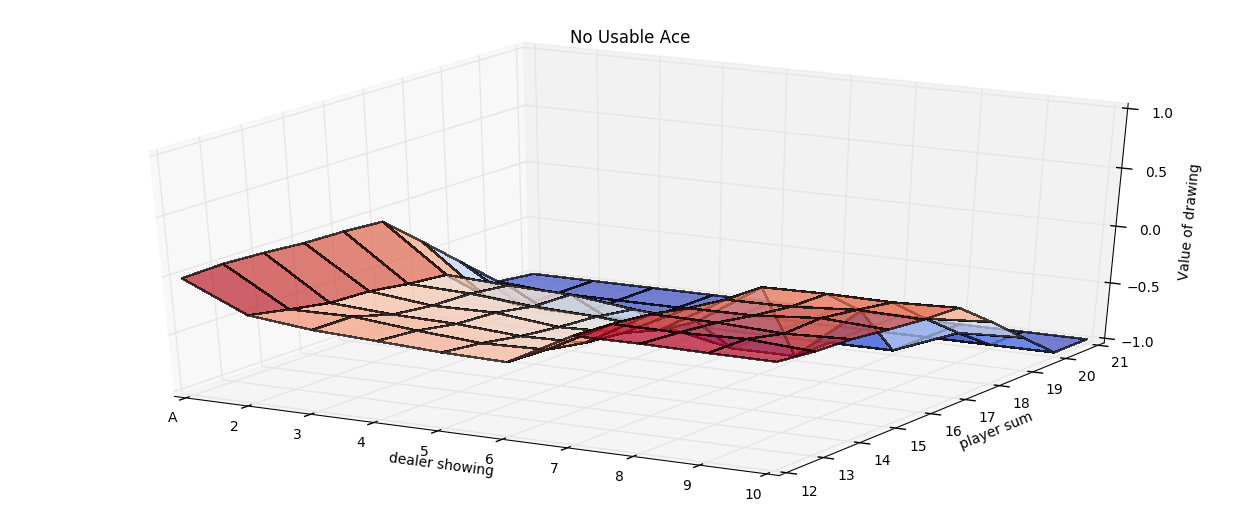

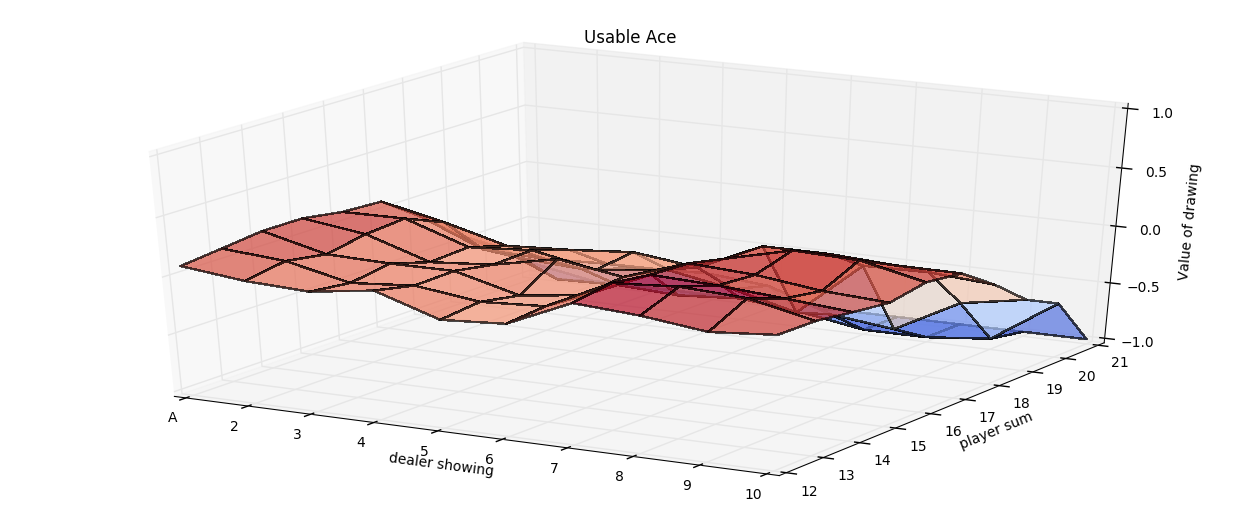

In [12]:
vi.plot_state_data(P, 'Value of drawing', 'surface')

### Dump Matrix Contents 

In [13]:
def a_star(av):
    #return '{0:.2f}'.format(av[1]).rjust(5)
    if av[0] > av[1]:
        return 'stick'
    elif av[0] == av[1]:
        return '====='

    return '     '

def printPolicy(PI):
    print
    print 'Policy'
    for k in [0,1]:
        print 'usabe ace (1 or 11): ', 'yes' if k == 1 else 'no'
        print 'dlr\plyr    ', '       '.join(['{0}'.format(12+j) for j in range(10)])
        for i in range(10):
            print '{0}'.format(1+i).ljust(8), [a_star(PI[i,j,k]) for j in range(10)]
        print 

def printMatrix(M):
    print
    print 'Matrix'
    for k in [0,1]:
        print 'action (stick or draw): ', 'draw' if k == 1 else 'stick'
        print 'dlr\plyr    ', '       '.join(['{0}'.format(12+j) for j in range(10)])
        for i in range(10):
            print '{0}'.format(1+i).ljust(8), ['{0:.2f}'.format(M[i,j, 0, k]) for j in range(10)]
        print 

def printMatrixInt(M):
    print
    print 'Matrix'
    for k in [0,1]:
        print 'action (stick or draw): ', 'draw' if k == 1 else 'stick'
        print 'dlr\plyr    ', '       '.join(['{0}'.format(12+j) for j in range(10)])
        for i in range(10):
            print '{0}'.format(1+i).ljust(8), ['%d' % (M[i,j, 0, k]) for j in range(10)]
        print 

In [14]:
printPolicy(PI)


Policy
usabe ace (1 or 11):  no
dlr\plyr     12       13       14       15       16       17       18       19       20       21
1        ['stick', 'stick', 'stick', 'stick', 'stick', 'stick', 'stick', 'stick', 'stick', 'stick']
2        ['stick', 'stick', 'stick', 'stick', 'stick', 'stick', 'stick', 'stick', 'stick', 'stick']
3        ['stick', 'stick', 'stick', 'stick', 'stick', 'stick', 'stick', 'stick', 'stick', 'stick']
4        ['stick', 'stick', 'stick', 'stick', 'stick', 'stick', 'stick', 'stick', 'stick', 'stick']
5        ['stick', 'stick', 'stick', 'stick', 'stick', 'stick', 'stick', 'stick', 'stick', 'stick']
6        ['stick', 'stick', 'stick', 'stick', 'stick', 'stick', 'stick', 'stick', 'stick', 'stick']
7        ['stick', 'stick', 'stick', 'stick', 'stick', 'stick', 'stick', 'stick', 'stick', 'stick']
8        ['stick', 'stick', 'stick', 'stick', 'stick', 'stick', 'stick', 'stick', 'stick', 'stick']
9        ['stick', 'stick', 'stick', 'stick', 'stick', 'stick', 'stick

In [15]:
printMatrix(Q)


Matrix
action (stick or draw):  stick
dlr\plyr     12       13       14       15       16       17       18       19       20       21
1        ['-0.76', '-0.78', '-0.78', '-0.77', '-0.78', '-0.77', '-0.51', '-0.25', '0.01', '0.24']
2        ['-0.29', '-0.28', '-0.28', '-0.31', '-0.29', '-0.29', '-0.02', '0.27', '0.52', '0.76']
3        ['-0.25', '-0.27', '-0.24', '-0.25', '-0.26', '-0.24', '0.03', '0.28', '0.51', '0.77']
4        ['-0.21', '-0.23', '-0.21', '-0.23', '-0.21', '-0.23', '0.05', '0.31', '0.55', '0.77']
5        ['-0.16', '-0.16', '-0.16', '-0.16', '-0.17', '-0.18', '0.08', '0.33', '0.55', '0.79']
6        ['-0.14', '-0.17', '-0.16', '-0.16', '-0.12', '-0.13', '0.20', '0.37', '0.61', '0.80']
7        ['-0.46', '-0.48', '-0.49', '-0.46', '-0.46', '-0.48', '0.28', '0.53', '0.69', '0.84']
8        ['-0.49', '-0.51', '-0.52', '-0.48', '-0.50', '-0.49', '-0.25', '0.47', '0.72', '0.87']
9        ['-0.54', '-0.55', '-0.53', '-0.56', '-0.54', '-0.54', '-0.29', '-0.08', '0.64', '0

In [16]:
printMatrixInt(rewardMatrix)


Matrix
action (stick or draw):  stick
dlr\plyr     12       13       14       15       16       17       18       19       20       21
1        ['-3414', '-3317', '-3472', '-3268', '-3426', '-3316', '-2123', '-997', '54', '610']
2        ['-1266', '-1234', '-1234', '-1318', '-1214', '-1210', '-88', '1079', '3044', '1946']
3        ['-1105', '-1157', '-1033', '-1089', '-1080', '-1017', '135', '1096', '3004', '1917']
4        ['-926', '-992', '-906', '-988', '-883', '-916', '189', '1240', '3146', '1946']
5        ['-708', '-704', '-696', '-715', '-719', '-772', '323', '1309', '3194', '1992']
6        ['-639', '-735', '-690', '-688', '-513', '-557', '842', '1460', '3578', '2010']
7        ['-2049', '-2125', '-2119', '-2018', '-1964', '-2010', '1194', '2126', '4146', '2159']
8        ['-2107', '-2246', '-2244', '-2053', '-2120', '-2012', '-1013', '1890', '4247', '2198']
9        ['-2386', '-2461', '-2287', '-2421', '-2337', '-2188', '-1143', '-329', '3798', '2298']
10       ['-10300', '-1